## 26x26のウエハに限定して機械学習させる
- データオーギュメンテーション（鏡映，回転を追加）

### import，入力データの読み込み

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/LSWMD.pkl


In [2]:
import os
from os.path import join

import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datapath = join('data', 'wafer')

print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

GPU: 0
Using TensorFlow backend.


['LSWMD.pkl']


### データについて

In [3]:
df=pd.read_pickle("../input/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
waferMap          811457 non-null object
dieSize           811457 non-null float64
lotName           811457 non-null object
waferIndex        811457 non-null float64
trianTestLabel    811457 non-null object
failureType       811457 non-null object
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


- データセットは811,457枚のウエハマップから構成されている．

In [4]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


- ウエハマップのそれぞれの列から得られる情報はないが，インスタンスごとにダイサイズが異なることがわかる．
- ウエハマップのダイサイズをチェックするための変数`WaferMapDim`を定義する．（縦，横の値）

In [5]:
df = df.drop(['waferIndex'], axis = 1)

In [6]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
738795,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1507.0,lot44593,[],[],"(43, 44)"
447418,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",712.0,lot27457,[],[],"(32, 29)"
317207,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1534.0,lot19280,[],[],"(45, 43)"
506286,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",710.0,lot31461,[],[],"(32, 29)"
576797,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",686.0,lot36063,[],[],"(31, 28)"


- 不良パターンと学習orテストラベルを数値で表す．

In [7]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [8]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [9]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

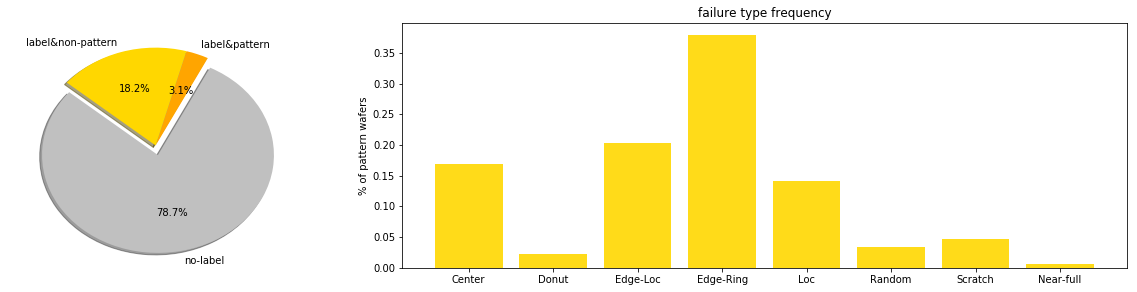

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

- 結果として，172,950枚のウエハは不良ラベルを持ち，78.7%のウエハは不良ラベルがない．
- また，ラベル付きのウエハのうち，実際に不良パターンがあるのは全体のわずか3.1%(25,519枚)であり，残りの147,431枚のウエハは不良パターンが`none`となっている．
- その結果，実際に不良パターンがあるのは3.1%(25,519枚）だけであり，計算量は大幅に削減される．
- 上の2つ目の図から，データセットは高い不均衡分布を示していることがわかる．

### 26x26のデータに対して処理

In [11]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [12]:
sub_df.head()

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
150,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
152,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
153,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
154,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0


In [13]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [14]:
mask_x = np.zeros((24, 24))
dummy_x = cv2.resize(x[0], (24,24))
mask_x[dummy_x == 1] = 1 
mask_x[dummy_x == 2] = 1 
mask_x = mask_x.reshape((1, 24,24))

In [15]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


- 26x26のウエハが14366枚抽出できた．

- 最初のデータを可視化してみる．

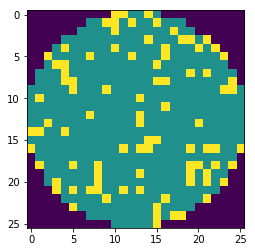

Faulty case : ['none'] 


In [16]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

In [17]:
x = x.reshape((-1, 26, 26, 1))
x.shape

(14366, 26, 26, 1)

In [18]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [19]:
faulty_case_dict =dict()

In [20]:
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y[y==f])))
    faulty_case_dict[i] = f

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


- 14366枚の26x26ウエハの不良パターンは上記のようになっている．

In [21]:
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [22]:
new_x.shape

(14366, 26, 26, 3)

- new_xを(14366, 26, 26, 3)とし，最後の次元にはウエハの値(0, 1, 2)がそれぞれの値毎にベクトルとしてまとめられている．
- ウエハデータの各ピクセルは，0:ウエハなし，1:正常，2:不良を表す．

### オートエンコーダで学習

#### エンコーダとデコーダのモデルを学習

- モデルの定義をする．

In [23]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [24]:
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26, 26, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 26, 26, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_________________________________________________________________


- 層は
    - 入力層
    - 畳み込み層
    - プーリング層
    - 転置畳み込み層
    - アップサンプリング層

In [25]:
epoch=30
batch_size=1024

- 学習を開始する．
- `new_x`を`new_x`にエンコードしデコードする．

In [26]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=1)

Epoch 1/30
14366/14366 [==============================] - 1s 103us/step - loss: 0.1662
Epoch 2/30
14366/14366 [==============================] - 1s 40us/step - loss: 0.0968
Epoch 3/30
14366/14366 [==============================] - 1s 42us/step - loss: 0.0884
Epoch 4/30
14366/14366 [==============================] - 1s 42us/step - loss: 0.0781
Epoch 5/30
14366/14366 [==============================] - 1s 41us/step - loss: 0.0695
Epoch 6/30
14366/14366 [==============================] - 1s 42us/step - loss: 0.0620
Epoch 7/30
14366/14366 [==============================] - 1s 41us/step - loss: 0.0566
Epoch 8/30
14366/14366 [==============================] - 1s 44us/step - loss: 0.0521
Epoch 9/30
14366/14366 [==============================] - 1s 41us/step - loss: 0.0479
Epoch 10/30
14366/14366 [==============================] - 1s 40us/step - loss: 0.0436
Epoch 11/30
14366/14366 [==============================] - 1s 42us/step - loss: 0.0395
Epoch 12/30
14366/14366 [==========================

- エンコーダだけのモデルを定義する．

In [27]:
encoder = models.Model(input_tensor, latent_vector)

- デコーダだけのモデルを定義する．

In [28]:
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

- `encoder`を使って元のウエハ画像をエンコードする．

In [29]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

- エンコードされた潜伏的な不良ウエハにノイズを負荷する．

In [30]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

- 元のウエハ画像

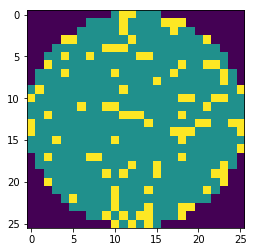

In [31]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

- ノイズが付加されたウエハ画像

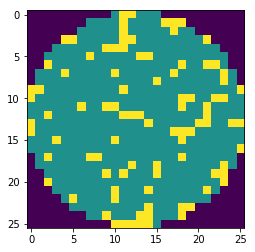

In [32]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

### データオーギュメンテーション

- データオーギュメンテーションを行う関数を定義する．
- 鏡映，回転を行う

In [33]:
# augment function define (add rotate, flip)
def gen_data(wafer, label):
    # Encode input wafer
    #encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    aug_x = np.zeros((1, 26, 26, 3))
    
    datagen = ImageDataGenerator(rotation_range = 90, horizontal_flip = True, vertical_flip = True)
    
    ite = 20 if label != 'none' else 2
    
    gen = datagen.flow(wafer, batch_size = len(wafer))
    for i in range(ite):
        data = next(gen)
        #print(data.shape)
        aug_x = np.concatenate((aug_x, data), axis = 0)
        '''
        for j, img in enumerate(data):
            plot_num = j+1
            plt.subplot(4, 5, plot_num)
            plt.tick_params(labelbottom=False)
            plt.tick_params(labelleft=False)
            plt.imshow(img)
        plt.show()
        '''
    encoded_x = encoder.predict(aug_x)
    print(encoded_x.shape)
        
    
    # Make wafer until total # of wafer to 15000
    if label != 'none':
        for i in range((40000//len(encoded_x)) + 1):
            noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
            noised_gen_x = decoder.predict(noised_encoded_x)
            gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    else:
        gen_x = aug_x
        
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

- 不良ラベルが付いているデータに対してデータオーギュメンテーションを行う．

In [36]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    #if f == 'none' : 
    #    continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

(1801, 13, 13, 64)
(21, 13, 13, 64)
(5921, 13, 13, 64)
(621, 13, 13, 64)
(5941, 13, 13, 64)
(321, 13, 13, 64)
(1481, 13, 13, 64)
(1441, 13, 13, 64)
(26979, 13, 13, 64)


In [37]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (368112, 26, 26, 3), new_y shape : (368112, 1)


In [38]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 41513
Donut : 40006
Edge-Loc : 41743
Edge-Ring : 40396
Loc : 41884
Near-full : 40141
Random : 41542
Scratch : 40420
none : 40467


- データオーギュメンテーションを行った結果，各不良データごとに約40000枚に増えた．
- 合計は368112枚となった．

In [39]:
new_y = y

### 学習を行う
- 不良ラベルを0-8の9次元のベクトルとして表現する．
- one-hotエンコーディングを行っている．

In [40]:
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i

In [41]:
# one-hot-encoding
new_y = to_categorical(new_y)

In [42]:
new_X=new_x
new_Y=new_y

- 学習データとテストデータに分割する．

In [43]:
x_train, x_test, y_train, y_test = train_test_split(new_X, new_Y,
                                                    test_size=0.33,
                                                    random_state=2019)

In [44]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (246635, 26, 26, 3), y : (246635, 9)
Test x: (121477, 26, 26, 3), y : (121477, 9)


- 学習データ246635枚，テストデータ121477枚．

- モデルの定義を行う．

In [45]:
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)

def create_model():
    global input_tensor
    
    conv = layers.Conv2D(32, (3,3), activation='relu', name='conv1')(input_tensor)
    padding = layers.ZeroPadding2D(padding=(1, 1), name='padding1')(conv)
    conv = layers.Conv2D(64, (3,3), activation='relu', name='conv2')(padding)
    padding = layers.ZeroPadding2D(padding=(1, 1), name='padding2')(conv)
    conv = layers.Conv2D(128, (3,3), activation='relu', name='conv3')(padding)
    padding = layers.ZeroPadding2D(padding=(1, 1), name='padding3')(conv)
    conv_out = layers.Conv2D(256, (3,3), activation='relu', name='conv4')(padding)

    gap_layer = layers.GlobalAveragePooling2D(name='GAP')
    output_layer = layers.Dense(9, activation='softmax', name='output')

    aver_pool = gap_layer(conv_out)
    output_tensor = output_layer(aver_pool)

    model = models.Model(input_tensor, output_tensor)

    model.compile(optimizer='Adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

    return model

- 3-Fold Cross validationで分割して学習する．

In [46]:
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=512, verbose=1) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Class Activation Map Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/30
164423/164423 [==============================] - 26s 157us/step - loss: 0.8938 - acc: 0.6555
Epoch 2/30
164423/164423 [==============================] - 25s 151us/step - loss: 0.6510 - acc: 0.7506
Epoch 3/30
164423/164423 [==============================] - 25s 151us/step - loss: 0.5699 - acc: 0.7888
Epoch 4/30
164423/164423 [==============================] - 25s 151us/step - loss: 0.5115 - acc: 0.8157
Epoch 5/30
164423/164423 [==============================] - 25s 151us/step - loss: 0.4732 - acc: 0.8314
Epoch 6/30
164423/164423 [==============================] - 25s 152us/step - loss: 0.4303 - acc: 0.8468
Epoch 7/30
164423/164423 [==============================] - 25s 151us/step - loss: 0.3973 - acc: 0.8576
Epoch 8/30
164423/164423 [==============================] - 25s 151us/step - loss: 0.3736 - acc: 0.8661
Epoch 9/30
164423/164423 [==============================] - 25s 151us/step - loss: 0.3504 - acc: 0.8738
Epoch 10/30
164423/164423 [==============================] - 25s

164424/164424 [==============================] - 25s 152us/step - loss: 0.2412 - acc: 0.9134
Epoch 19/30
164424/164424 [==============================] - 25s 152us/step - loss: 0.2289 - acc: 0.9178
Epoch 20/30
164424/164424 [==============================] - 25s 152us/step - loss: 0.2194 - acc: 0.9214
Epoch 21/30
164424/164424 [==============================] - 25s 152us/step - loss: 0.2183 - acc: 0.9220
Epoch 22/30
164424/164424 [==============================] - 25s 152us/step - loss: 0.2089 - acc: 0.9255
Epoch 23/30
164424/164424 [==============================] - 25s 152us/step - loss: 0.2006 - acc: 0.9284
Epoch 24/30
164424/164424 [==============================] - 25s 152us/step - loss: 0.1973 - acc: 0.9290
Epoch 25/30
164424/164424 [==============================] - 25s 151us/step - loss: 0.1915 - acc: 0.9314
Epoch 26/30
164424/164424 [==============================] - 25s 152us/step - loss: 0.1813 - acc: 0.9356
Epoch 27/30
164424/164424 [==============================] - 25s 15

- Cross validiationによる精度は99.10%であった．

- Cross validationなしで学習する．

In [47]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=50,
         batch_size=512,
         verbose=1
         )

Train on 246635 samples, validate on 121477 samples
Epoch 1/50
246635/246635 [==============================] - 45s 183us/step - loss: 0.8283 - acc: 0.6811 - val_loss: 0.6352 - val_acc: 0.7616
Epoch 2/50
246635/246635 [==============================] - 44s 179us/step - loss: 0.5992 - acc: 0.7755 - val_loss: 0.5500 - val_acc: 0.7961
Epoch 3/50
246635/246635 [==============================] - 44s 179us/step - loss: 0.5176 - acc: 0.8129 - val_loss: 0.4764 - val_acc: 0.8267
Epoch 4/50
246635/246635 [==============================] - 44s 179us/step - loss: 0.4519 - acc: 0.8375 - val_loss: 0.4377 - val_acc: 0.8498
Epoch 5/50
246635/246635 [==============================] - 44s 179us/step - loss: 0.3996 - acc: 0.8575 - val_loss: 0.3767 - val_acc: 0.8656
Epoch 6/50
246635/246635 [==============================] - 44s 179us/step - loss: 0.3625 - acc: 0.8703 - val_loss: 0.3469 - val_acc: 0.8750
Epoch 7/50
246635/246635 [==============================] - 44s 179us/step - loss: 0.3351 - acc: 0.879

- テストデータで評価．    

In [48]:
score = model.score(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)

121477/121477 [==============================] - 7s 55us/step
Testing Accuracy: 0.9687348222586718


- モデルは以下．
    - 入力層
    - 畳み込み層3つ
    - Flatten層（1次元に）
    - 全結合層3つ

In [49]:
model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 26, 26, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 24, 24, 32)        896       
_________________________________________________________________
padding1 (ZeroPadding2D)     (None, 26, 26, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 24, 24, 64)        18496     
_________________________________________________________________
padding2 (ZeroPadding2D)     (None, 26, 26, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 24, 24, 128)       73856     
_________________________________________________________________
padding3 (ZeroPadding2D)     (None, 26, 26, 128)       0         
__________

- accuracyグラフ，lossグラフは以下．
- 5epoch程度で落ち着いている．

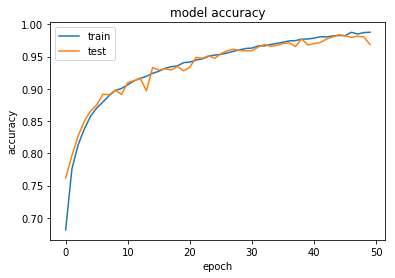

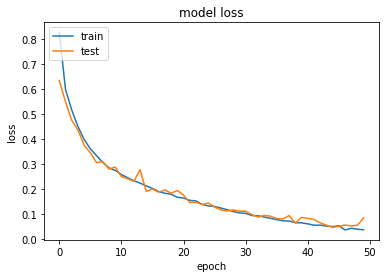

In [50]:
# accuracy plot 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### クラス活性化マップ

In [51]:
#set target wafer number
target_wafer_num = 2
# predict 
prob = model.model.predict(x_test[target_wafer_num].reshape(1,26,26,3))

In [52]:
aver_output = model.model.layers[7]
aver_model = models.Model(input_tensor, aver_output.output)
cam_result = aver_model.predict(x_test[target_wafer_num].reshape(1, 26, 26, 3))

In [53]:
weight_result = model.model.layers[-1].get_weights()[0]

In [54]:
def make_cam(cam_result, weight_result): 
    cam_arr = np.zeros((1,24, 24))
    for row in range(0,9):
        cam = np.zeros((1, 24, 24))
        for i, w in enumerate(weight_result[:, row]):
            cam += (w*cam_result[0,:,:,i]).reshape(24,24)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        cam[mask_x == 0] = 0
        cam_arr = np.concatenate((cam_arr, cam))
    return cam_arr[1:]

def display_activation(cam_arr, prob, wafer): 
    fig, ax = plt.subplots(9, 1, figsize=(50, 50))
    count = 0
    cam_arr[np.percentile(cam_arr, 0.8) > cam_arr] = 0
    for row in range(0,9):
        ax[row].imshow(np.argmax(wafer, axis=2))
        ax[row].imshow(cam_arr[row],cmap='Reds', alpha=0.7)
        ax[row].set_title('class : ' + faulty_case_dict[count]+', prob : {:.4f}'.format(prob[:, count][0]*100) + '%')
        count += 1

In [55]:
faulty_case_dict[np.argmax(y_test[target_wafer_num])]

'Edge-Loc'

faulty case : Edge-Loc


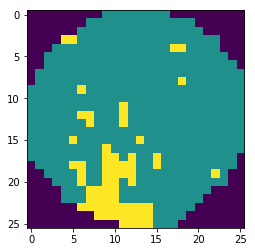

In [56]:
plt.imshow(np.argmax(x_test[target_wafer_num], axis=2))
print('faulty case : {}'.format(faulty_case_dict[np.argmax(y_test[target_wafer_num])]))

- 対象のウエハの画像と不良パターンの表示

In [57]:
cam_result.shape

(1, 24, 24, 256)

In [58]:
cam_arr = make_cam(cam_result, weight_result)

In [59]:
prob.shape

(1, 9)

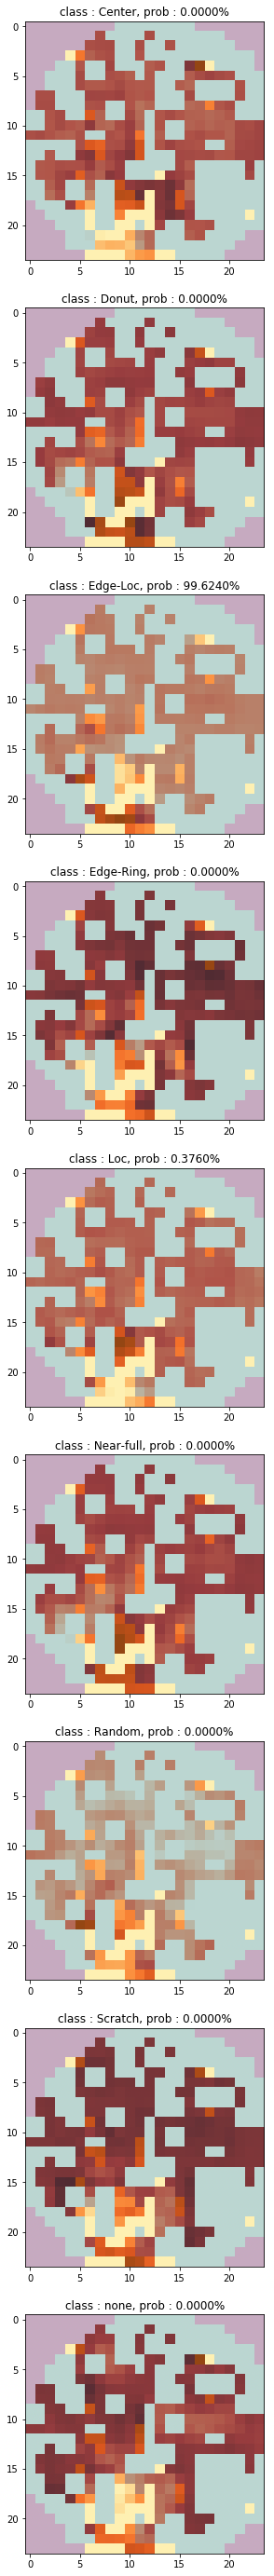

In [60]:
display_activation(cam_arr, prob, x_test[target_wafer_num])

- 活性化マップの表示
- ドーナツでは円形状にヒートマップの赤い部分が点在している

### CNN

In [61]:
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
def create_model():


    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

- 3-Fold Cross validationで分割して学習する．

In [62]:
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=1) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/30
164423/164423 [==============================] - 19s 118us/step - loss: 0.5644 - acc: 0.7964
Epoch 2/30
164423/164423 [==============================] - 17s 106us/step - loss: 0.1874 - acc: 0.9375
Epoch 3/30
164423/164423 [==============================] - 17s 106us/step - loss: 0.2696 - acc: 0.9291
Epoch 4/30
164423/164423 [==============================] - 17s 105us/step - loss: 0.1160 - acc: 0.9628
Epoch 5/30
164423/164423 [==============================] - 17s 106us/step - loss: 0.0340 - acc: 0.9912
Epoch 6/30
164423/164423 [==============================] - 17s 106us/step - loss: 0.0153 - acc: 0.9962
Epoch 7/30
164423/164423 [==============================] - 17s 106us/step - loss: 0.0078 - acc: 0.9983
Epoch 8/30
164423/164423 [==============================] - 17s 105us/step - loss: 0.0316 - acc: 0.9922
Epoch 9/30
164423/164423 [==============================] - 17s 106us/step - loss: 0.0031 - acc: 0.9996
Epoch 10/30
164423/164423 [==============================] - 17s

164424/164424 [==============================] - 17s 106us/step - loss: 0.0016 - acc: 0.9998
Epoch 18/30
164424/164424 [==============================] - 17s 106us/step - loss: 8.2273e-04 - acc: 0.9999
Epoch 19/30
164424/164424 [==============================] - 17s 105us/step - loss: 6.8740e-04 - acc: 0.9999
Epoch 20/30
164424/164424 [==============================] - 17s 105us/step - loss: 7.6532e-04 - acc: 0.9999
Epoch 21/30
164424/164424 [==============================] - 17s 106us/step - loss: 0.0013 - acc: 0.9998
Epoch 22/30
164424/164424 [==============================] - 17s 106us/step - loss: 0.0010 - acc: 0.9999
Epoch 23/30
164424/164424 [==============================] - 17s 105us/step - loss: 8.5966e-04 - acc: 0.9999
Epoch 24/30
164424/164424 [==============================] - 17s 106us/step - loss: 0.0010 - acc: 0.9999
Epoch 25/30
164424/164424 [==============================] - 17s 105us/step - loss: 8.4105e-04 - acc: 0.9999
Epoch 26/30
164424/164424 [====================

- Cross validiationによる精度は99.55%であった．

- Cross validationなしで学習する．

In [63]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=epoch,
         batch_size=batch_size,
         verbose=1           
         )

Train on 246635 samples, validate on 121477 samples
Epoch 1/30
246635/246635 [==============================] - 32s 131us/step - loss: 0.4317 - acc: 0.8486 - val_loss: 0.1595 - val_acc: 0.9461
Epoch 2/30
246635/246635 [==============================] - 31s 124us/step - loss: 0.1139 - acc: 0.9656 - val_loss: 0.0667 - val_acc: 0.9809
Epoch 3/30
246635/246635 [==============================] - 31s 124us/step - loss: 0.0296 - acc: 0.9927 - val_loss: 0.0264 - val_acc: 0.9939
Epoch 4/30
246635/246635 [==============================] - 31s 124us/step - loss: 0.0111 - acc: 0.9977 - val_loss: 0.0279 - val_acc: 0.9939
Epoch 5/30
246635/246635 [==============================] - 31s 124us/step - loss: 0.0250 - acc: 0.9933 - val_loss: 0.1684 - val_acc: 0.9524
Epoch 6/30
246635/246635 [==============================] - 31s 124us/step - loss: 0.0151 - acc: 0.9959 - val_loss: 0.0185 - val_acc: 0.9970
Epoch 7/30
246635/246635 [==============================] - 30s 124us/step - loss: 0.0039 - acc: 0.999

- テストデータで評価．    

In [64]:
score = model.score(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)

121477/121477 [==============================] - 5s 37us/step
Testing Accuracy: 0.9969953159857422


- acuurayは99.70%であった．

- モデルは以下．
    - 入力層
    - 畳み込み層3つ
    - Flatten層（1次元に）
    - 全結合層3つ

In [65]:
model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 26, 26, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 64)        9280      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 26, 26, 128)       73856     
_________________________________________________________________
flatten_4 (Flatten)          (None, 86528)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               44302848  
_________________________________________________________________
dense_11 (Dense)             (None, 128)               65664     
__________

- accuracyグラフ，lossグラフは以下．
- 5epoch程度で落ち着いている．

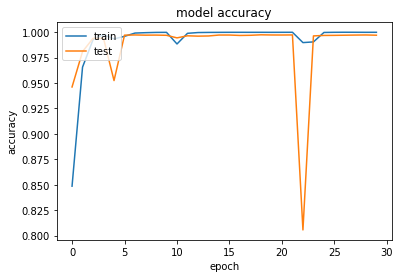

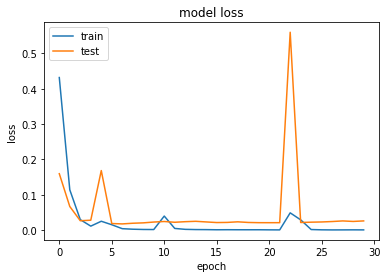

In [66]:
# accuracy plot 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [67]:
#y_train_pred = np.argmax(model.predict(x_train))
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
y_train_max = np.argmax(y_train, axis=1)
y_test_max = np.argmax(y_test, axis=1)

print(y_train_max[0])
print(y_train_pred[0])

train_acc2 = np.sum(y_train_max == y_train_pred, axis=0, dtype='float') / x_train.shape[0]
test_acc2 = np.sum(y_test_max == y_test_pred, axis=0, dtype='float') / x_test.shape[0]
print('Training acc: {}'.format(train_acc2*100))
print('Testing acc: {}'.format(test_acc2*100))
print("y_train_pred[:100]: ", y_train_pred[:100])
print ("y_train_max[:100]: ", y_train_max[:100])

121477/121477 [==============================] - 4s 36us/step
7
7
Training acc: 99.99553996796887
Testing acc: 99.69953159857423
y_train_pred[:100]:  [7 0 7 5 1 7 7 2 6 1 7 1 3 8 1 0 1 4 0 1 5 4 5 8 5 8 5 5 7 4 7 7 7 0 0 4 7
 5 6 1 1 0 6 8 7 7 8 4 3 1 8 7 8 3 6 7 8 7 1 1 7 2 4 6 2 1 8 0 1 4 0 5 5 3
 6 3 5 2 5 6 8 6 1 0 0 6 1 0 0 4 5 4 8 1 0 4 8 3 2 4]
y_train_max[:100]:  [7 0 7 5 1 7 7 2 6 1 7 1 3 8 1 0 1 4 0 1 5 4 5 8 5 8 5 5 7 4 7 7 7 0 0 4 7
 5 6 1 1 0 6 8 7 7 8 4 3 1 8 7 8 3 6 7 8 7 1 1 7 2 4 6 2 1 8 0 1 4 0 5 5 3
 6 3 5 2 5 6 8 6 1 0 0 6 1 0 0 4 5 4 8 1 0 4 8 3 2 4]


### 混同行列

In [68]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
Normalized confusion matrix


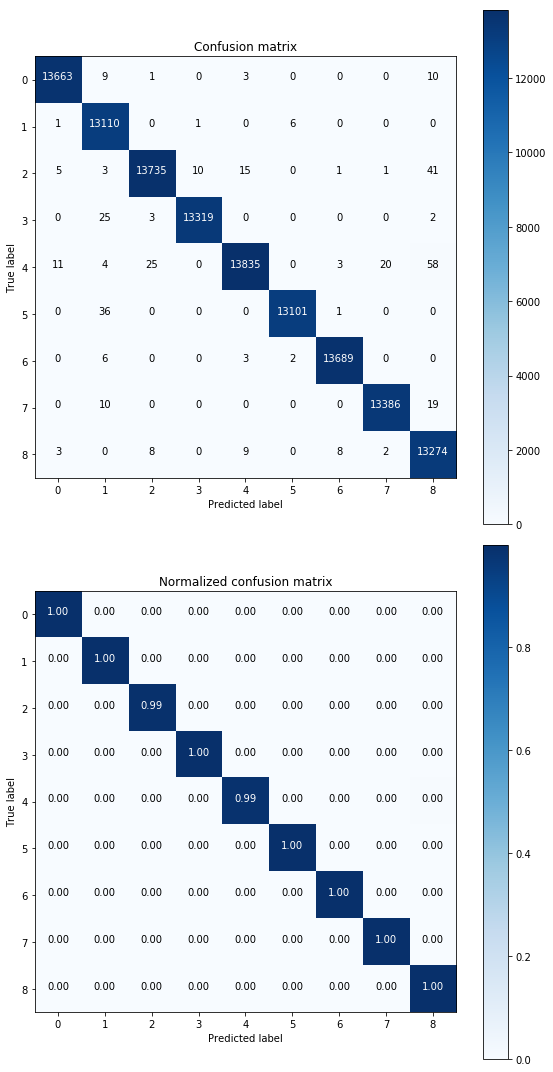

In [69]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_max, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

### クラス活性化マップ

In [82]:
#set target wafer number
target_wafer_num = 100000
# predict 
prob = model.model.predict(x_test[target_wafer_num].reshape(1,26,26,3))

In [83]:
aver_output = model.model.layers[3]
aver_model = models.Model(input_tensor, aver_output.output)
cam_result = aver_model.predict(x_test[target_wafer_num].reshape(1, 26, 26, 3))

In [84]:
print(model.model.layers[3].name)

conv2d_13


In [85]:
weight_result = model.model.layers[-1].get_weights()[0]

In [86]:
def make_cam(cam_result, weight_result): 
    cam_arr = np.zeros((1,26, 26))
    for row in range(0,9):
        cam = np.zeros((1, 26, 26))
        for i, w in enumerate(weight_result[:, row]):
            cam += (w*cam_result[0,:,:,i]).reshape(26,26)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        cam[mask_x == 0] = 0
        cam_arr = np.concatenate((cam_arr, cam))
    return cam_arr[1:]

def display_activation(cam_arr, prob, wafer): 
    fig, ax = plt.subplots(9, 1, figsize=(50, 50))
    count = 0
    cam_arr[np.percentile(cam_arr, 0.8) > cam_arr] = 0
    for row in range(0,9):
        ax[row].imshow(np.argmax(wafer, axis=2))
        ax[row].imshow(cam_arr[row],cmap='Reds', alpha=0.7)
        ax[row].set_title('class : ' + faulty_case_dict[count]+', prob : {:.4f}'.format(prob[:, count][0]*100) + '%')
        count += 1

In [87]:
faulty_case_dict[np.argmax(y_test[target_wafer_num])]

'Edge-Loc'

faulty case : Edge-Loc


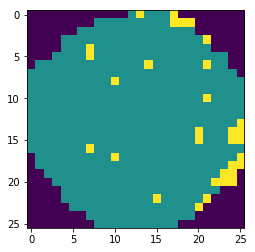

In [88]:
plt.imshow(np.argmax(x_test[target_wafer_num], axis=2))
print('faulty case : {}'.format(faulty_case_dict[np.argmax(y_test[target_wafer_num])]))

- 対象のウエハの画像と不良パターンの表示

In [89]:
cam_result.shape

(1, 26, 26, 128)

In [90]:
mask_x = np.zeros((26, 26))
dummy_x = cv2.resize(x[0], (26,26))
mask_x[dummy_x == 1] = 1 
mask_x[dummy_x == 2] = 1 
mask_x = mask_x.reshape((1, 26,26))

In [91]:
cam_arr = make_cam(cam_result, weight_result)

In [92]:
prob.shape

(1, 9)

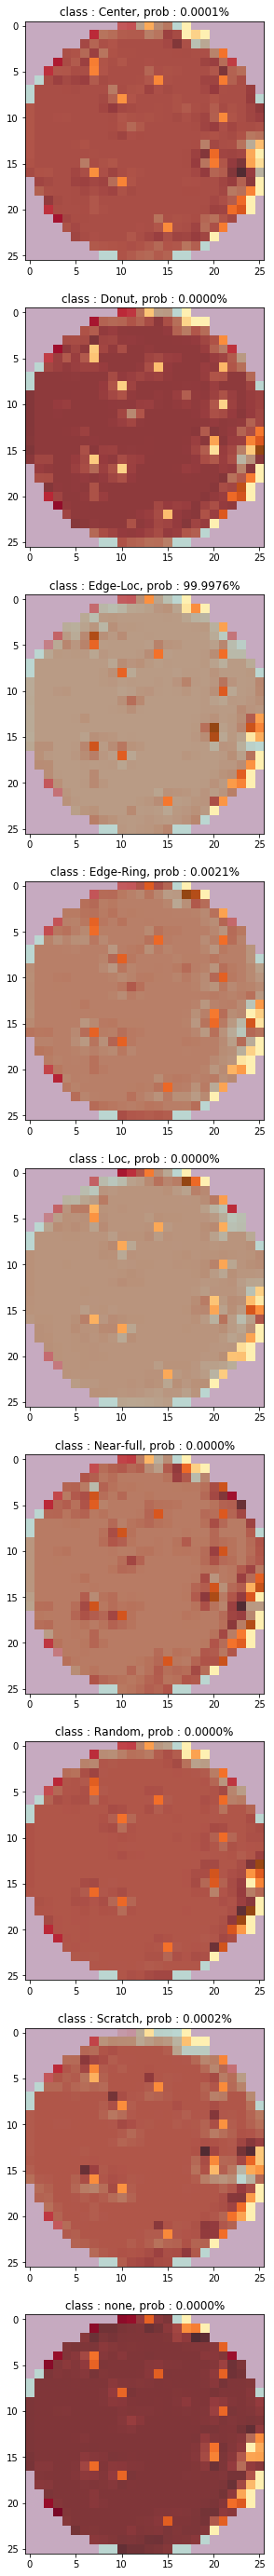

In [93]:
display_activation(cam_arr, prob, x_test[target_wafer_num])

- 活性化マップの表示
- ドーナツでは円形状にヒートマップの赤い部分が点在している